### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

### 1. Importing your libraries and data

In [4]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm #
import os
import warnings 
import nasdaqdatalink
warnings.filterwarnings("ignore") 
plt.style.use('fivethirtyeight')

In [47]:
data=nasdaqdatalink.get_table('WB/DATA',series_id='SE.TER.ENRR', country_code='USA')

In [48]:
data.shape

(51, 5)

In [49]:
data.head()

,series_id,country_code,country_name,year,value
None,,,,,
0,SE.TER.ENRR,USA,United States,2022,79.361931
1,SE.TER.ENRR,USA,United States,2021,84.855087
2,SE.TER.ENRR,USA,United States,2020,87.567657
3,SE.TER.ENRR,USA,United States,2019,87.888710
4,SE.TER.ENRR,USA,United States,2018,88.299179


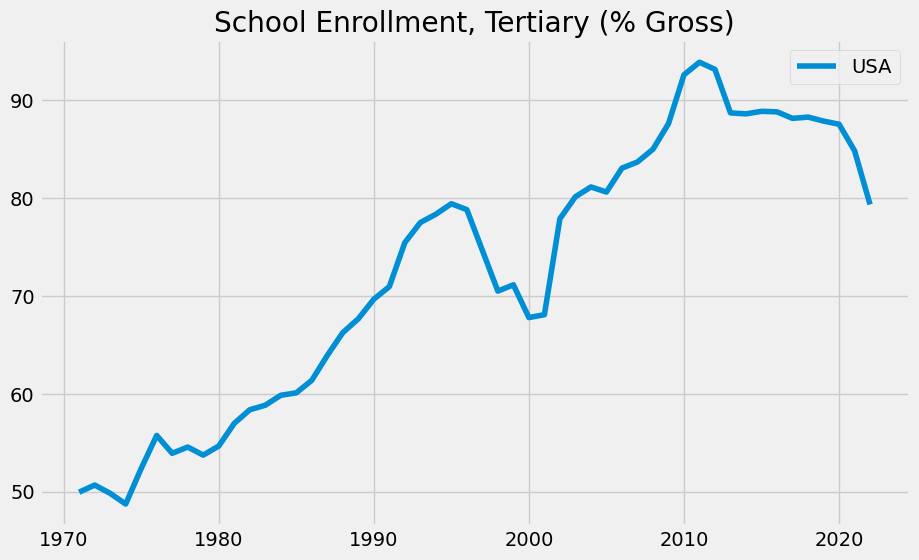

In [51]:
# Plot the original time series
plt.figure(figsize=(10, 6))
plt.plot(data['year'], data['value'], label='USA')
plt.title('School Enrollment, Tertiary (% Gross)')
plt.legend()
plt.show()

# 2. Subsetting, wrangling, and cleaning time-series data

In [52]:
# Convert 'year' to datetime format 
data['year'] = pd.to_datetime(data['year'], format='%Y')


In [53]:
data.head()

,series_id,country_code,country_name,year,value
None,,,,,
0,SE.TER.ENRR,USA,United States,2022-01-01,79.361931
1,SE.TER.ENRR,USA,United States,2021-01-01,84.855087
2,SE.TER.ENRR,USA,United States,2020-01-01,87.567657
3,SE.TER.ENRR,USA,United States,2019-01-01,87.888710
4,SE.TER.ENRR,USA,United States,2018-01-01,88.299179


In [55]:
# Check for missing values 
data.isnull().sum() 

series_id       0
country_code    0
country_name    0
year            0
value           0
dtype: int64

In [56]:
# Check for duplicates

dups = data.duplicated()
dups.sum()

0

### 3. Time-series analysis: decomposition

In [60]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data['value'], model='additive', period=1)

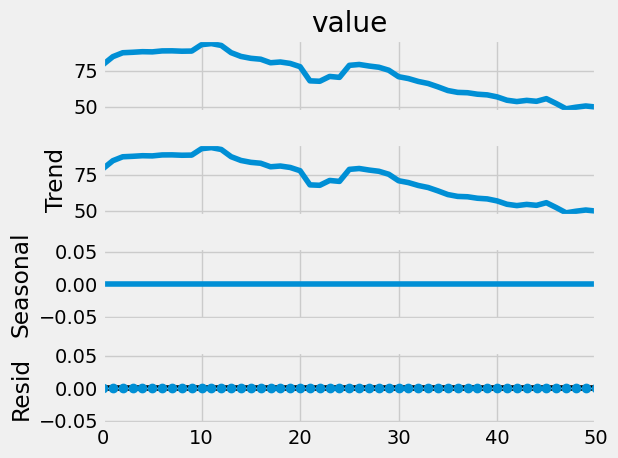

In [61]:
# Plot the decomposition
decomposition.plot()
plt.show()

### 4. Testing for stationarity

In [64]:

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): 
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data['value'])

Dickey-Fuller Stationarity test:
Test Statistic                  0.214982
p-value                         0.973089
Number of Lags Used             0.000000
Number of Observations Used    50.000000
Critical Value (1%)            -3.568486
Critical Value (5%)            -2.921360
Critical Value (10%)           -2.598662
dtype: float64


Since the p-value is much greater than 0.05 and the test statistic is not below critical values, we conclude that the time series is non-stationary.

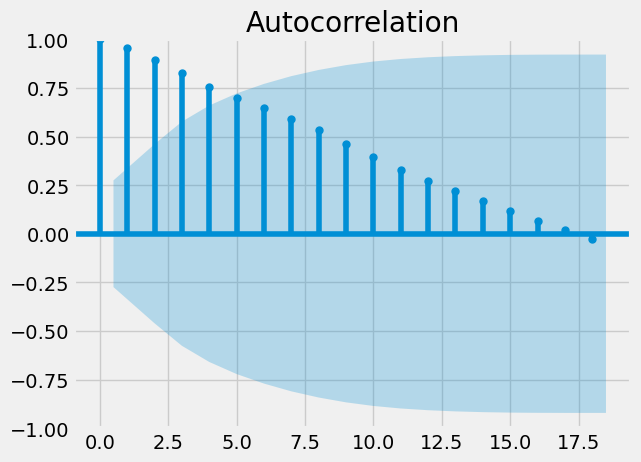

In [69]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(data['value'])
plt.show()

### 5. Stationarizing the data

In [92]:
# Create a subset of the data with only 'year' and 'value' columns
data_sub = data[['year', 'value']].copy()

# Check the first few rows to confirm
print(data_sub.head())


           year      value
None                      
0    2022-01-01  79.361931
1    2021-01-01  84.855087
2    2020-01-01  87.567657
3    2019-01-01  87.888710
4    2018-01-01  88.299179


In [93]:
# Check for NaN values in the 'value' column
print(data_sub['value'].isna().sum()) 

# If there are NaN values, you can drop them or fill them as needed
data_sub.dropna(subset=['value'], inplace=True) 


0


In [94]:
# Perform differencing
data_sub['value_diff'] = data_sub['value'] - data_sub['value'].shift(1)

# Check the first few rows after differencing
print(data_sub.head())


           year      value  value_diff
None                                  
0    2022-01-01  79.361931         NaN
1    2021-01-01  84.855087    5.493156
2    2020-01-01  87.567657    2.712570
3    2019-01-01  87.888710    0.321053
4    2018-01-01  88.299179    0.410469


In [95]:
# Drop the NaN values in 'value_diff' 
data_sub.dropna(subset=['value_diff'], inplace=True)

# Check if NaN values are removed
print(data_sub.isna().sum()) 


year          0
value         0
value_diff    0
dtype: int64


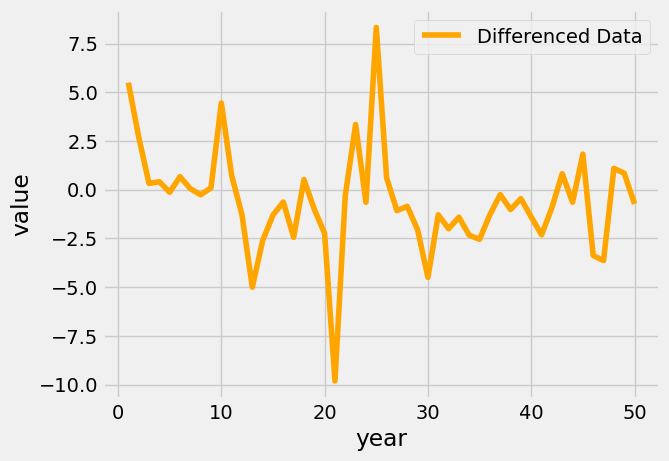

In [97]:
# Plot the differenced data
plt.plot(data_sub['value_diff'], label='Differenced Data', color='orange')

# Add labels and title
plt.xlabel('year')
plt.ylabel('value')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [98]:
dickey_fuller(data_sub['value_diff'])

Dickey-Fuller Stationarity test:
Test Statistic                -5.665519e+00
p-value                        9.170990e-07
Number of Lags Used            0.000000e+00
Number of Observations Used    4.900000e+01
Critical Value (1%)           -3.571472e+00
Critical Value (5%)           -2.922629e+00
Critical Value (10%)          -2.599336e+00
dtype: float64


Since the p-value is very small and the test statistic is more negative than the critical values, we can reject the null hypothesis and conclude that the series is stationary.

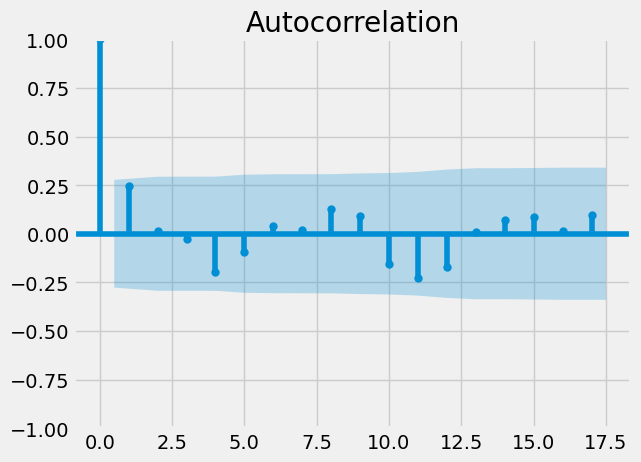

In [99]:
plot_acf(data_sub['value_diff'])
plt.show()